In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random as rnd
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from IPython.display import Image 
from StringIO import StringIO
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def titanic(train, test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df, test_df]

    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

    test_df.head(10)
    return (train_df, test_df)

In [3]:
train_df, test_df = titanic("./train.csv", "./test.csv")

In [4]:
train_df = pd.get_dummies(train_df, ["Embarked"])

test_df = pd.get_dummies(test_df, ['Embarked'])

In [5]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22,1,0,7.2500,1,2,0,0,0,1
1,1,1,1,38,1,0,71.2833,3,2,0,1,0,0
2,1,3,1,26,0,0,7.9250,2,1,1,0,0,1
3,1,1,1,35,1,0,53.1000,3,2,0,0,0,1
4,0,3,0,35,0,0,8.0500,1,1,1,0,0,1


In [6]:
x_train = train_df.iloc[:713,1:]
y_train = train_df.iloc[:713,0]
x_test = train_df.iloc[713:,1:]
y_test = train_df.iloc[713:,0]

In [7]:
def hyperparameters(model, parameters, train, test):
    acc_scorer = make_scorer(accuracy_score)
    grid_search = GridSearchCV(model, parameters, scoring = acc_scorer)
    return grid_search.fit(train, test)

In [20]:
clf = RandomForestClassifier(random_state = None)

parameters = {#'n_estimators': [32, 128], 
#               'max_features': ['log2', 'auto', None], 
#               'criterion': ['gini'],
#               'max_depth': [5, 8], 
#               'min_samples_split': [4, 8, 16],
              'min_samples_leaf': [3, 6, 8, 12]
             }

grid_search = hyperparameters(clf, parameters, x_train, y_train)
clf = grid_search.best_estimator_
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
accuracy_score(y_test, prediction)

0.8539325842696629

In [18]:
def cv_plot(grid):
    train_score = grid.cv_results_['mean_train_score']
    test_score = grid.cv_results_['mean_test_score']
    X = pd.DataFrame(grid.cv_results_).iloc[:,4]
    plt.plot(X, train_score, c = 'r')
    plt.plot(X, test_score, c = 'b')
    plt.legend()
    plt.show()

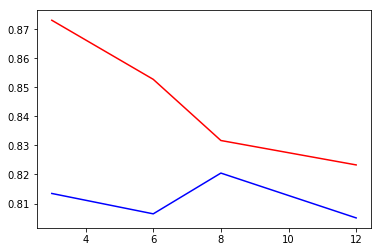

In [21]:
cv_plot(grid_search)

In [155]:
df = pd.DataFrame(np.array([test_df['PassengerId'], prediction]).T,columns = ['PassengerId', 'Survived'])

df.to_csv("randomforest_prediction.csv", index = False)

In [164]:
prediction = clf.predict(test_df.iloc[:, 1:])

In [17]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_samples_leaf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.031756,0.007263,0.803647,0.872372,3,{u'min_samples_leaf': 3},1,0.802521,0.884211,0.819328,0.863158,0.78903,0.869748,0.003540,0.001317,0.012390,0.008793
1,0.025021,0.005599,0.795231,0.854144,6,{u'min_samples_leaf': 6},2,0.777311,0.867368,0.823529,0.850526,0.78481,0.844538,0.000858,0.000278,0.020263,0.009665
